###**Importing Libraries**

In [1]:
# Code Block 1
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

!pip install text_hammer
import text_hammer as th
import seaborn as sns

from wordcloud import STOPWORDS
from collections import defaultdict

# import tqdm
from tqdm.auto import tqdm
# instantiate tqdm before use 
tqdm.pandas()

!pip install transformers
from transformers import AutoTokenizer,TFBertModel

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from wordcloud import WordCloud

max_len = 36

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 29.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.1 MB/s 
     |████████████████████████████████| 182 kB 74.9 MB/s 
     |████████████████████████████████| 7.6 MB 66.6 MB/s 


###**Loading Dataset:**

In [2]:
# Code Block 2
# load the dataset available in the github in raw format, read only the required columns 
train_data = pd.read_csv('https://raw.githubusercontent.com/raghunandanbhat/Predicting-disaster-tweets-with-BERT/main/Data/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('https://raw.githubusercontent.com/raghunandanbhat/Predicting-disaster-tweets-with-BERT/main/Data/test.csv',usecols=['id','text'])
#sample_data = pd.read_csv('https://raw.githubusercontent.com/raghunandanbhat/Predicting-disaster-tweets-with-BERT/main/Data/sample_submission.csv')

In [3]:
# Code Block 3
# checking the size of the dataset
print("Shape of Training set:", train_data.shape)
print("Shape of Testing set:", test_data.shape)

Shape of Training set: (7613, 3)
Shape of Testing set: (3263, 2)


In [4]:
# Code Block 4
# checkout the training dataset
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Code Block 5
# checkout the test dataset
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


###**Pre-processing the tweets:**

In [6]:
# Code Block 6
# text preprocessing to remove special characters, emails, html tags and convert all tweets to lower case
def text_preprocessing(df,col_name):
    df[col_name] = df[col_name].progress_apply(lambda x:str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)

In [7]:
# Code Block 7
# pre processing text column from the trainging data using the above method
train_cleaned_data = text_preprocessing(train_data,'text')

# Added: pre-processing test data to maintain consistancy 
test_cleaned_data = text_preprocessing(test_data, 'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [8]:
# Code Block 8
# checkout the data after pre-processing step
train_cleaned_data.head(10)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,i am on top of the hill and i can see a fire i...,1
8,14,there is an emergency evacuation happening now...,1
9,15,i am afraid that the tornado is coming to our ...,1


Here, 

* Target 1 indicates any accident or disaster 

* Target 0 indicates a formal tweets with not much attention


In [9]:
# Code Block 9
# making a copy of cleaned tarining  and testing dataset
train_data = train_cleaned_data.copy()

# Added: Making a copy of cleaned test dataset
test_data = test_cleaned_data.copy()

###**Data Visualization:**

####**Visualization using Word Cloud:**

In [10]:
# Code Block 10
# This process is only for visualization. train and test data for model will have stopwords in it
# download the stop words from NLTK and remove stop words from tweets
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

train_data_vis = train_data.copy()
train_data_vis['text'] = train_data_vis['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(train_data_vis.head())

# Edit: Added this code to remove stopwords from the test data to maintain consistency.
test_data_vis = test_data.copy()
print("-----------------------------------------------------------------------")
test_data_vis['text'] = test_data_vis['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(test_data_vis.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   id                                               text  target
0   1       deeds reason earthquake may allah forgive us       1
1   4              forest fire near la ronge sask canada       1
2   5  residents asked shelter place notified officer...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  got sent photo ruby alaska smoke wildfires pou...       1
-----------------------------------------------------------------------
   id                                               text
0   0                        happened terrible car crash
1   2  heard earthquake different cities stay safe ev...
2   3  forest fire spot pond geese fleeing across str...
3   9              apocalypse lighting spokane wildfires
4  11             typhoon soudelor kills 28 china taiwan


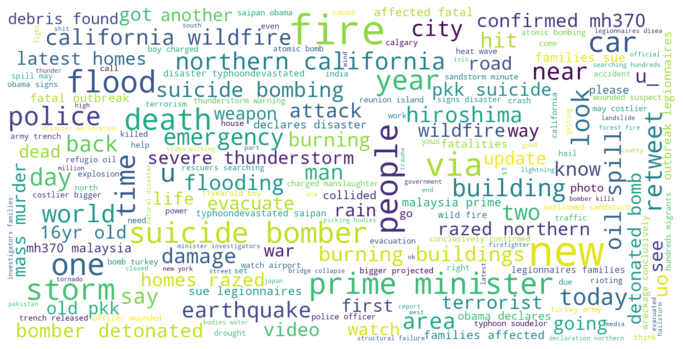

In [11]:
# Code Block 11
# Visualizing the dataset using Word Cloud after removing stopwords
# Filter all the disaster tweeets
disaster_tweets = train_data_vis[train_data_vis.target == 1]
disaster_string = list(map(lambda x: x, disaster_tweets.text))
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

# generate the word cloud from strings in disaster tweets 
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)

# plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

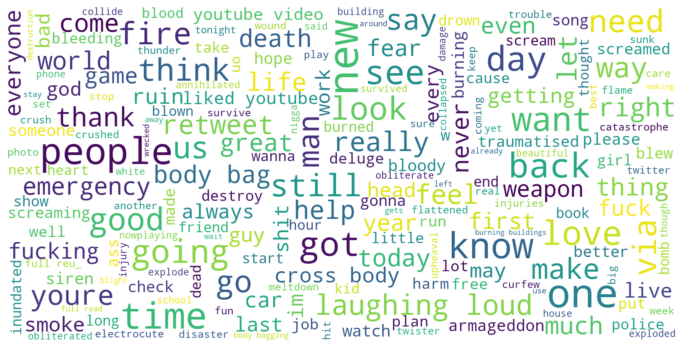

In [12]:
# Code Block 12
# Word cloud for tweets which are not disaster related 

# extract the tweets which are not realted to disaster
formal_tweets = train_data_vis[train_data_vis.target == 0]
formal_string = list(map(lambda x: x, formal_tweets.text))
formal_string = pd.Series(formal_string).str.cat(sep=' ')

# create a world cloud using the strins
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)

# plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

####**Visualizing the Class Distribution**

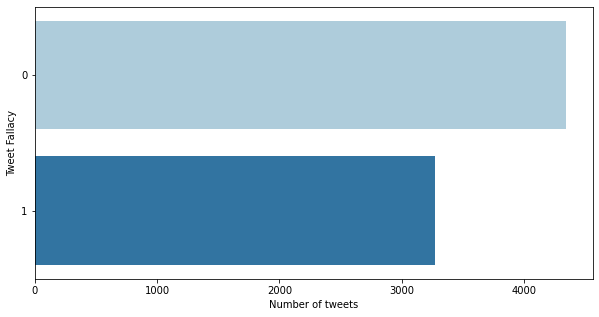

In [13]:
# Code Block 13
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data_vis,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

####**Visualizing the meta-features**

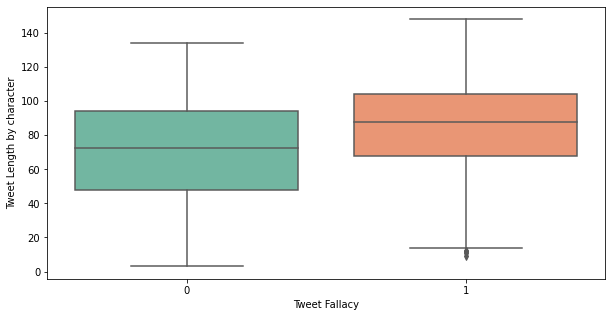

In [14]:
# Code Block 14
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data_vis['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data_vis,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

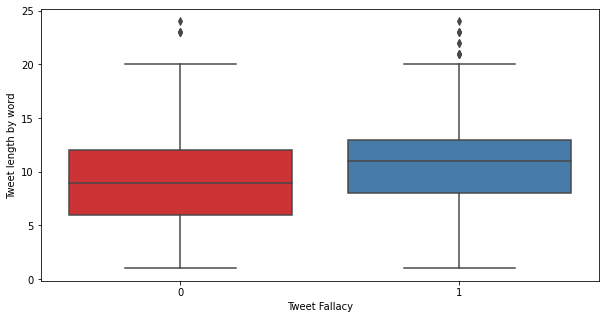

In [15]:
# Code Block 15
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data_vis['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data_vis,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [16]:
# Code Block 16
# word_count
train_data_vis['word_count'] = train_data_vis['text'].apply(lambda x: len(str(x).split()))
test_data_vis['word_count'] = test_data_vis['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data_vis['unique_word_count'] = train_data_vis['text'].apply(lambda x: len(set(str(x).split())))
test_data_vis['unique_word_count'] = test_data_vis['text'].apply(lambda x: len(set(str(x).split())))

# Commented: Stop words and URLs alread removed, no point in calculating their frequencies

# # stop_word_count
# train_data_vis['stop_word_count'] = train_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# test_data_vis['stop_word_count'] = test_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# # url_count
# train_data_vis['url_count'] = train_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# test_data_vis['url_count'] = test_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data_vis['mean_word_length'] = train_data_vis['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data_vis['mean_word_length'] = test_data_vis['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data_vis['char_count'] = train_data_vis['text'].apply(lambda x: len(str(x)))
test_data_vis['char_count'] = test_data_vis['text'].apply(lambda x: len(str(x)))

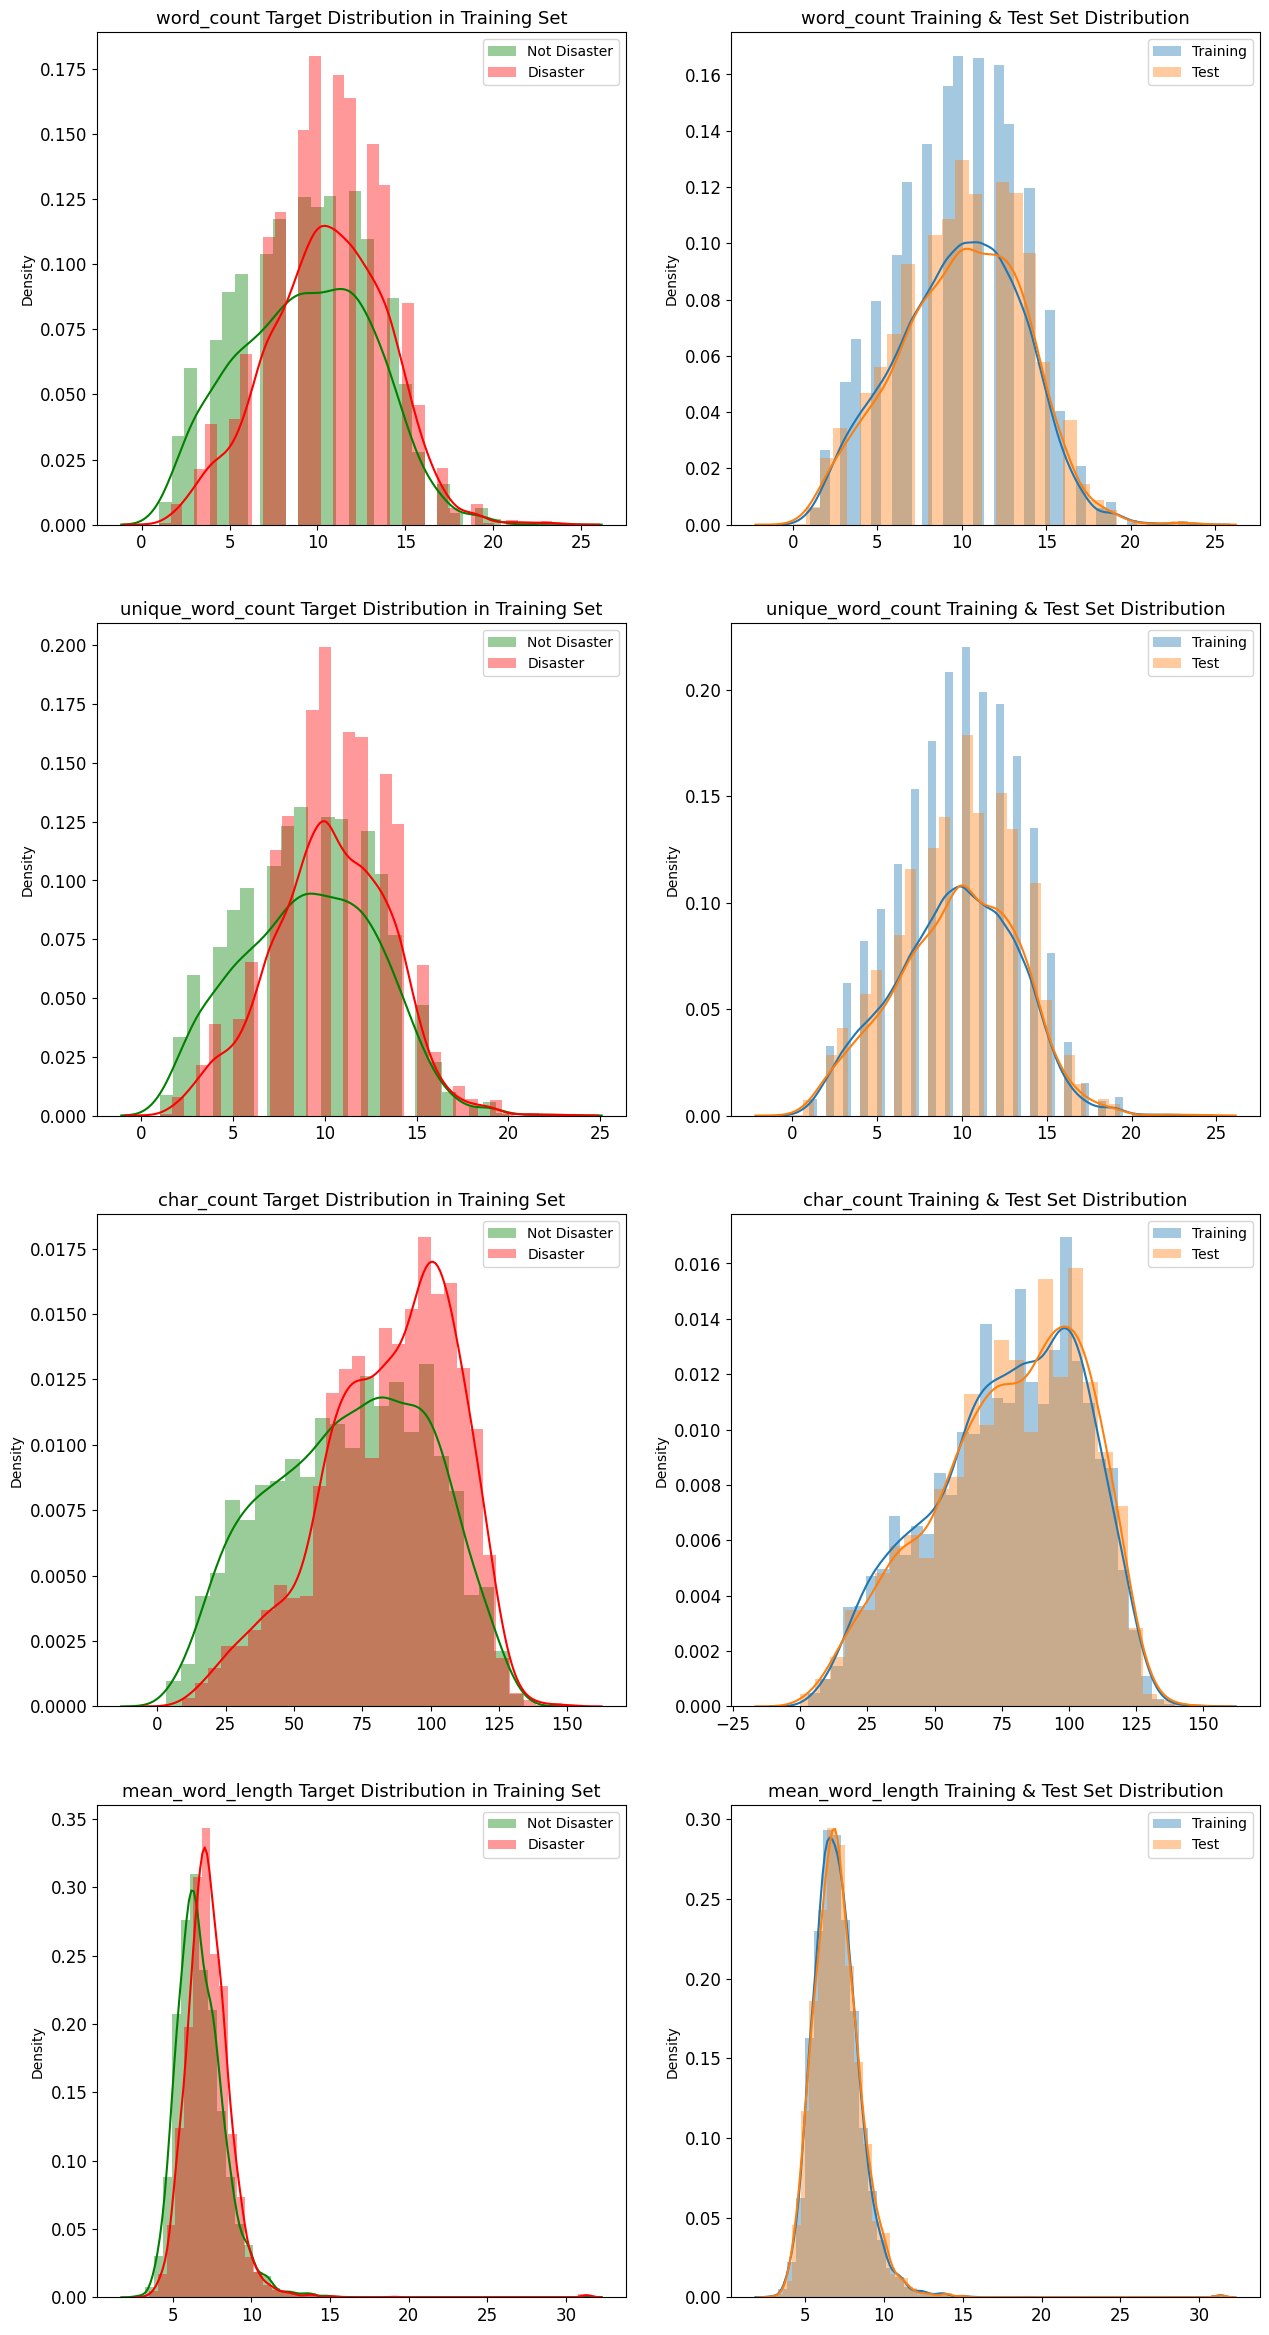

In [17]:
# Code Block 17
METAFEATURES = ['word_count', 'unique_word_count', 'char_count', 'mean_word_length']
DISASTER_TWEETS = train_data_vis['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 30), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data_vis.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data_vis.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data_vis[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data_vis[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [18]:
# Edit: Class distribution visualization is alread done. This is an extra-block, commented

# fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
# plt.tight_layout()

# train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
# sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

# axes[0].set_ylabel('')
# axes[1].set_ylabel('')
# axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
# axes[0].tick_params(axis='x', labelsize=15)
# axes[0].tick_params(axis='y', labelsize=15)
# axes[1].tick_params(axis='x', labelsize=15)
# axes[1].tick_params(axis='y', labelsize=15)

# axes[0].set_title('Target Distribution in Training Set', fontsize=13)
# axes[1].set_title('Target Count in Training Set', fontsize=13)

# plt.show()

###**BERT - Bidirectional Encoder Representations from Transformers**

* BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

* The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.

####**Loading the BERT Model:**

In [19]:
# Code Block 18
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
# Code Block 19
# Testing the Tokenizer
test_token = tokenizer('Happy learning and keep kaggling &*&*&&')
print(type(test_token))
print(test_token)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'input_ids': [101, 3407, 4083, 1998, 2562, 10556, 13871, 2989, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


####**Conversion of Tweets into BERT input format:**

In [21]:
# Code Block 20
print("Maximum length of tweets:",max([len(x.split()) for x in train_data.text]))
max_length = 36

Maximum length of tweets: 35


In [22]:
# Code Block 21
x_train = tokenizer(
                    text=train_data.text.tolist(),
                    add_special_tokens=True,
                    max_length=36,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                   )

x_train

{'input_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  2683, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [23]:
# Code Block 22
print("Shape of input token ids:", x_train['input_ids'].shape)
print("Shape of atteniton mask:", x_train['attention_mask'].shape)

Shape of input token ids: (7613, 36)
Shape of atteniton mask: (7613, 36)


In [24]:
# Code Block 23
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

####**Building the Model Architecture:**

In [25]:
# Code Block 24
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)

out = tf.keras.layers.Dropout(0.1)(out)

out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [26]:
# Code Block 25
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [27]:
# Code Block 26
# optimizer for the model
model_optimizer = Adam(
                        learning_rate=6e-06, # this learning rate is for bert model.
                        epsilon=1e-08,
                        decay=0.01,
                        clipnorm=1.0
                      )

# Set loss and metrics
model_loss = BinaryCrossentropy(from_logits = True)
model_accuracy = BinaryAccuracy('accuracy')

# Compile the model
model.compile(
              optimizer=model_optimizer,
              loss=model_loss, 
              metrics=model_accuracy
             )

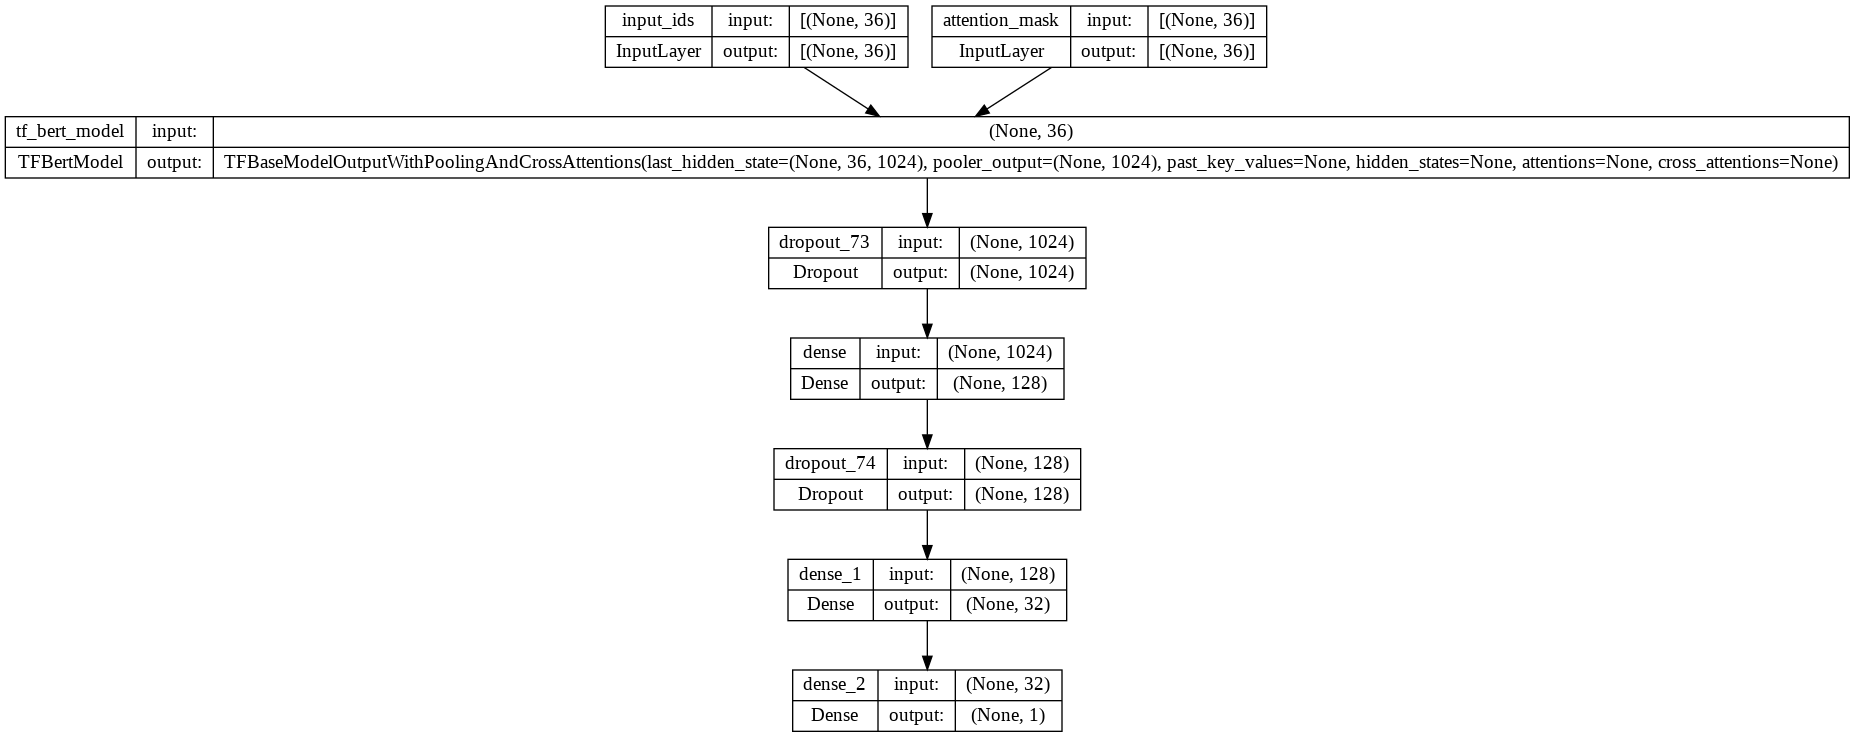

In [28]:
# Code Block 27
# Plot the model layers 
plot_model(model, show_shapes = True)

####**Training the Model**

In [29]:
# Code Block 28
# training the model
final = model.fit(
                  x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']},
                  y = y_train,
                  validation_split=0.1,
                  epochs=15,
                  batch_size=32
                 )

Epoch 1/15
215/215 [==============================] - 228s 870ms/step - loss: 0.5228 - accuracy: 0.7589 - val_loss: 0.4213 - val_accuracy: 0.8320
Epoch 2/15
215/215 [==============================] - 176s 817ms/step - loss: 0.4161 - accuracy: 0.8281 - val_loss: 0.4170 - val_accuracy: 0.8307
Epoch 3/15
215/215 [==============================] - 175s 813ms/step - loss: 0.3902 - accuracy: 0.8448 - val_loss: 0.4080 - val_accuracy: 0.8333
Epoch 4/15
215/215 [==============================] - 177s 823ms/step - loss: 0.3730 - accuracy: 0.8555 - val_loss: 0.4148 - val_accuracy: 0.8281
Epoch 5/15
215/215 [==============================] - 176s 818ms/step - loss: 0.3643 - accuracy: 0.8581 - val_loss: 0.4166 - val_accuracy: 0.8346
Epoch 6/15
215/215 [==============================] - 172s 800ms/step - loss: 0.3533 - accuracy: 0.8619 - val_loss: 0.4112 - val_accuracy: 0.8346
Epoch 7/15
215/215 [==============================] - 172s 798ms/step - loss: 0.3512 - accuracy: 0.8656 - val_loss: 0.4227 -

####**Plotting the Loss and Acuracy Curve:**

In [30]:
# Code Block 29
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']

    epochs_plot = np.arange(1, len(loss) + 1)
    
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

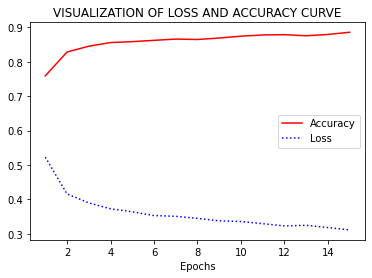

In [31]:
# Code Block 30
visual_accuracy_and_loss(final)

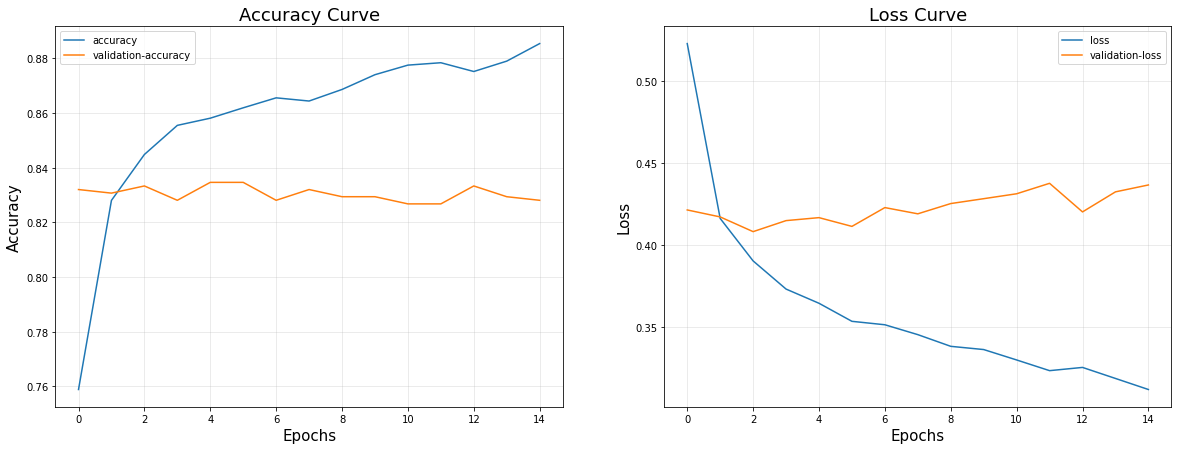

In [33]:
# Code Block 31
# Plot the loss and accuracy curves  

#Defining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch, final.history['accuracy'], label="accuracy") # Accuracy curve 
plt.plot(final.epoch, final.history['val_accuracy'], label="validation-accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch, final.history['loss'], label="loss") # Loss curve 
plt.plot(final.epoch, final.history['val_loss'], label="validation-loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


####**Testing the Model**

In [60]:
# Code Block 32
# Test Input 
x_test = tokenizer(
                    text=test_data.text.tolist(),
                    add_special_tokens=True,
                    max_length=36,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                  )

**PREDICTION:**

In [61]:
# Code Block 33
# predict
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted

102/102 [==============================] - 26s 252ms/step


array([[0.96203274],
       [0.96998614],
       [0.9623886 ],
       ...,
       [0.9806384 ],
       [0.87165934],
       [0.95983404]], dtype=float32)

In [62]:
# Code Block 34
# convert the decimal prediction values to either 0 or 1
y_predicted = np.where(predicted>0.5,1,0)
y_predicted

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [63]:
# Code Block 35
# Reshape and attach the predicted values to test dataframe

y_predicted = y_predicted.reshape((1,3263))[0]

test_data['predicted_target'] = y_predicted

print("Prediction on Test data")
print("Number of Disaster Tweets: ", test_data.predicted_target.value_counts()[1])
print("Number of Non-Disaster Tweets: ", test_data.predicted_target.value_counts()[0])

Prediction on Test data
Number of Disaster Tweets:  1296
Number of Non-Disaster Tweets:  1967


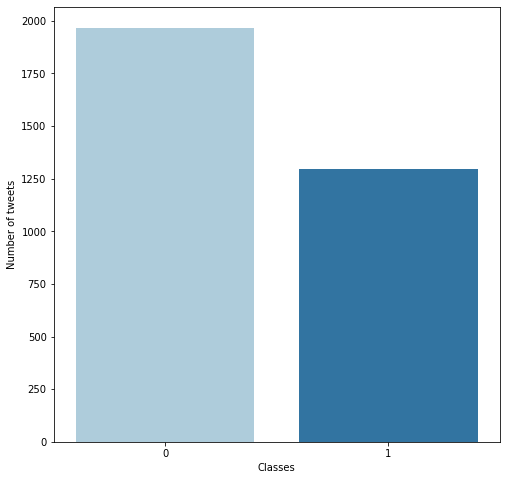

In [64]:
# Code Block 36
# sample_data.to_csv('submission.csv',index = False)
plt.figure(figsize=(8, 8))
sns.countplot(x='predicted_target',data = test_data,palette="Paired")

plt.xlabel("Classes")
plt.ylabel("Number of tweets")
plt.show()

In [65]:
# Code Block 37
# Test a random tweet

# Replace the tweet with any tweet you like and run this block
tweet = "ChatGPT is scary"

tokenized_tweet = tokenizer(
                    text=tweet,
                    max_length=36,
                    truncation=False,
                    padding='max_length', 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                  )

prediction = model.predict({'input_ids':tokenized_tweet['input_ids'],'attention_mask':tokenized_tweet['attention_mask']})

if (prediction > 0.5):
  print("Disaster!")
else:
  print("Not a Disaster")

1/1 [==============================] - 0s 77ms/step
Not a Disaster
